# Evolutionary Algorithm Visualization

This notebook visualizes the progress and results of the Evolutionary Algorithm for ODE discovery.
We will run the EA for a few generations and plot:
1. Fitness evolution (MSE trend) for each island.
2. Trajectories of the best discovered model vs. the ground truth.

In [1]:
import sys
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure code is in path
sys.path.append(os.getcwd())

from data.generate_data import WarfarinTMDDDataset
from evolution.llm_interface import LLMClient
from evolution.models import Island, Individual
from evolution.algorithm import EvolutionEngine
from evolution.models import integrate_euler

# Setup plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
print("--- Setting up Data ---")

# 1. Setup Data (Same as previous experiments)
true_params = {
    'CL': 0.1, 'V1': 1.0, 'Q': 0.5, 'V2': 2.0,
    'kon': 0.01, 'koff': 0.005, 'kdeg': 0.001, 'ksyn': 0.002, 
    'initial_state': [10.0, 0.0, 0.0, 5.0],
    't_start': 0, 't_end': 50, 'num_points': 50
}
generator = WarfarinTMDDDataset(generation_parameters=true_params)
gt_data = generator.generate()
time_points = generator.get_time_points()
obs_indices = [0, 2] # x1, x3

observed_data = gt_data[:, obs_indices]

--- Setting up Data ---


In [ ]:
print("--- Setting up EA ---")

# 2. Setup Islands
# We will run small populations for visualization speed

n_init_pop = 3 

islands = [
    Island(num_vars=2),
    Island(num_vars=3),
    Island(num_vars=4)
]

# 3. Initialize Population
llm = LLMClient()
problem_desc = "Pharmacokinetic/Pharmacodynamic system of Warfarin. Central and Peripheral compartments. Drug binds to a target. Clearance from Central."

print("Initializing Populations (This may take a minute)... ")
for island in islands:
    print(f"  Initializing Island (Dim {island.num_vars})...")
    while len(island.population) < n_init_pop:
        code = llm.generate_initial_model(island.num_vars)
        if code:
            ind = Individual(code)
            if ind.compile():
                ind.evaluate(observed_data, obs_indices, time_points)
                island.add_individual(ind)
                print(".", end="", flush=True)
        else:
            print("x", end="", flush=True)
    print()

--- Setting up EA ---
Initializing Populations (This may take a minute)... 
  Initializing Island (Dim 2)...
...
  Initializing Island (Dim 3)...
...
  Initializing Island (Dim 4)...
...


In [7]:
for island in islands:
    for pop in island.population:
        print(pop.fitness)

131926080.0
nan
nan
inf
31.42511558532715
nan
inf
nan
nan


In [5]:
# 4. Run Evolution Loop
data_pkg = {'observed_data': observed_data}
engine = EvolutionEngine(islands, llm, data_pkg, obs_indices, time_points, n_iterations=20)

num_generations = 20 # Run for 5 generations
history = []

print("Starting Evolution...")
for g in range(num_generations):
    gen_stats = engine.run_generation()
    history.extend(gen_stats)

EvolutionEngine loaded evolution/config.json
Starting Evolution...
--- Generation 0 (Stagnation: 0/20) ---
Evolving Island 1 (Vars: 3)...


ValueError: probabilities contain NaN

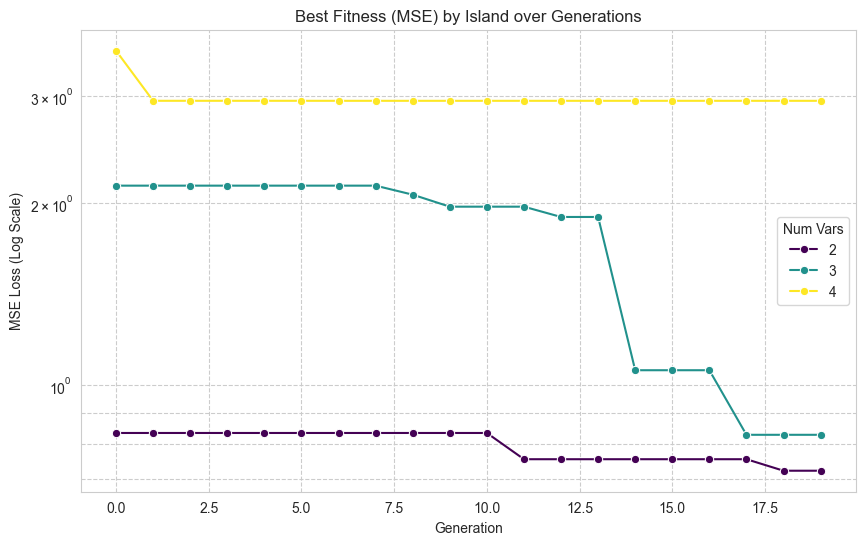

In [5]:
# 5. Plot Fitness History
df_history = pd.DataFrame(history)

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_history, x='generation', y='best_fitness', hue='num_vars', marker='o', palette='viridis')
plt.title('Best Fitness (MSE) by Island over Generations')
plt.xlabel('Generation')
plt.ylabel('MSE Loss (Log Scale)')
plt.yscale('log')
plt.legend(title='Num Vars')
plt.grid(True, which="both", ls="--")
plt.show()

Best Overall Fitness: 0.7234
Best Model Dimension: 2


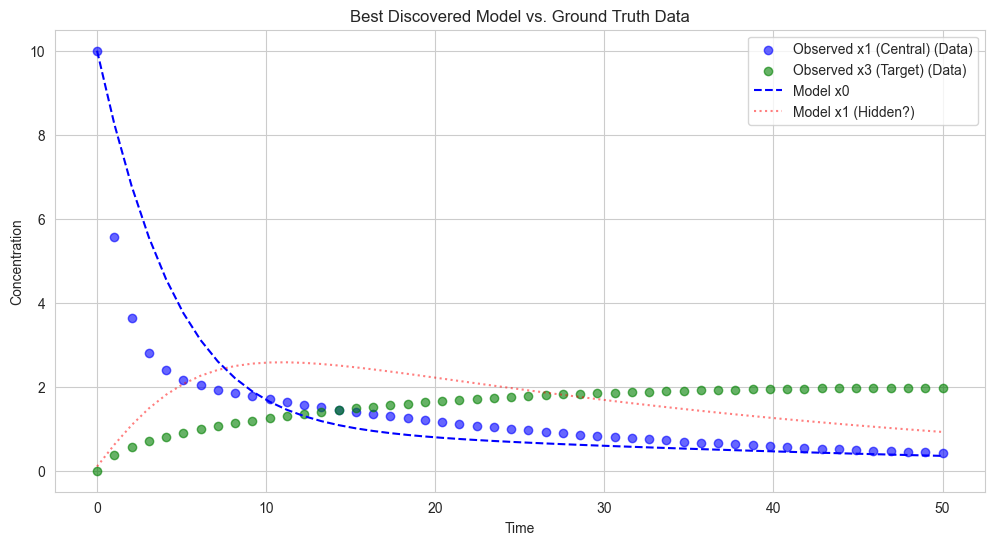

In [6]:
# 6. Visualize Best Model Trajectory
best_overall = None
for island in islands:
    b = island.get_best()
    if b:
        if best_overall is None or b.fitness < best_overall.fitness:
            best_overall = b

print(f"Best Overall Fitness: {best_overall.fitness:.4f}")
print(f"Best Model Dimension: {best_overall.model.num_vars}")

# Simulate Best Model
# Re-integrate to get full trajectory
# Note: reconstruction of x0 logic must be identical to 'evaluate'
x0 = torch.zeros(best_overall.model.num_vars)
for i, obs_idx in enumerate(obs_indices):
    if obs_idx < best_overall.model.num_vars:
        x0[obs_idx] = observed_data[0, i]
x0[x0 == 0] = 0.1

with torch.no_grad():
    pred_traj = integrate_euler(best_overall.model, x0, time_points).numpy()

# Plotting
plt.figure(figsize=(12, 6))

# Plot Ground Truth Observations
colors = ['blue', 'green']
labels = ['Observed x1 (Central)', 'Observed x3 (Target)']

for i, obs_idx in enumerate(obs_indices):
    plt.scatter(time_points, observed_data[:, i], color=colors[i], label=f'{labels[i]} (Data)', alpha=0.6)

# Plot Model Predictions
# We plot the indices that theoretically match.
# Assumption: Model indices 0 and 1 match obs indices 0 and 2 if dim=2? 
# Or we assume naive mapping: index 0 -> obs 0, index 2 -> obs 1 if available?
# In the 'evaluate' method, we matched by explicit index.
# for i, obs_idx in enumerate(obs_indices):
#    if obs_idx in valid_indices...

for i, obs_idx in enumerate(obs_indices):
    if obs_idx < pred_traj.shape[1]:
        plt.plot(time_points, pred_traj[:, obs_idx], color=colors[i], linestyle='--', label=f'Model x{obs_idx}')

# Plot Hidden if available (e.g. x2)
if pred_traj.shape[1] > 1 and 1 not in obs_indices:
    plt.plot(time_points, pred_traj[:, 1], color='red', linestyle=':', label='Model x1 (Hidden?)', alpha=0.5)

plt.title('Best Discovered Model vs. Ground Truth Data')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

In [7]:
print("Best Discovered Code:")
print(best_overall.code)

Best Discovered Code:
import torch
import torch.nn as nn

class ProposedModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.num_vars = 2
        
        # Define learnable parameters here
        self.params = nn.ParameterDict({
            'k_el': nn.Parameter(torch.tensor(0.1)),  # Clearance rate from central compartment
            'k_cp': nn.Parameter(torch.tensor(0.05)), # Transfer rate central to peripheral
            'k_pc': nn.Parameter(torch.tensor(0.03)), # Transfer rate peripheral to central
            'k_bind': nn.Parameter(torch.tensor(0.02)), # Binding rate of drug to target
            'k_unbind': nn.Parameter(torch.tensor(0.01)) # Unbinding rate of drug from target
        })
        
    def forward(self, t, state):
        # state is a list/tensor of size 2
        # Unpack state variables if needed
        x_central, x_peripheral = state[0], state[1]
        
        # access params via self.params
        k_el = self.params['k_el']
 